# **Agricultural drought in central South America - observational analysis**

Final event definitions after discussion on Jan 23rd
- exclude ERA5 altogether
- use OND precipitation
- compare trend in SPI3 with trend in 3-month precip
- also look at temperature trend (which will be used in model validation)

In [117]:
import sys; sys.path.append('/home/clair/wwa'); from wwa import *

from xclim.indices.stats import fit

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

def get_spi(pr, months = range(1,13), calibration_period = slice("1980", "2010")):
    
    ## NB CURRENTLY NOTHING IN PLACE TO HANDLE DRY PERIODS IN THE TIME SERIES - USE WITH CAUTION!
    
    # create empty list to hold results
    spi_monthly = []
    
    # fit each calendar month in turn
    for m in months:
        
        # select current calendar month
        pr_m = pr.sel(time = pr.time.dt.month == m)
        
        # estimate parameters over calibration period (PWM seems to give more robust fit, so using xclim fit method - also applies over whole spatial array)
        pr_cal = pr_m.sel(time = calibration_period).copy()
        pars = fit(pr_cal.dropna("time", "all"), dist = "gamma", method = "PWM")
        
        # normalise all values using fitted parameters (again, apply over whole spatial array)
        spi_m = xr.apply_ufunc(lambda pr, dparams : norm.ppf(gamma.cdf(pr, *dparams)), pr_m, pars, 
                               input_core_dims = [["time"],["dparams"]], output_core_dims = [["time"]], vectorize = True).assign_coords(time = pr_m.time)
        
        # replace +ve (-ve) infinite values with finite maximum (minimum) in each grid cell
        spi_finite = xr.concat([spi_m.where(~np.isinf(spi_m)), 
                                xr.ones_like(spi_m).where(spi_m == np.inf) * spi_m.where(spi_m < np.inf).max("time"),
                                xr.ones_like(spi_m).where(spi_m == -np.inf) * spi_m.where(spi_m > -np.inf).min("time")], "new").sum("new").copy()
        
        # append to list of monthly SPI for concatenation
        spi_monthly.append(spi_finite)
        
    # concatenate monthly fitted values, reorder & relabel
    spi = xr.concat(spi_monthly, "time").sortby("time").rename("spi")
    
    # clean out existing attributes and replace with new variable description
    for k in list(spi.attrs.keys()): del spi.attrs[k]
    spi = spi.assign_attrs(long_name = "SPI_3", notes = "Calibrated against "+str(calibration_period.start)+"-"+str(calibration_period.stop))
    spi = spi.where(~np.isnan(pr)).dropna("time", "all")
    
    return spi

---
## **Event maps**

### **Drought classification**

In [128]:
# load latest data, discretize to get drought classifications
spi = {ens : xr.open_dataset("data/"+ens+"_spi3_monthly.nc").spi.sel(time = "2022-12").squeeze(drop = True) for ens in ["cpc", "chirps"]}
spi = {k : xr.apply_ufunc(np.digitize, v, kwargs={'bins': [-np.inf, -2, -1.55, -1.25, -.75, -.5]}).where(~np.isnan(v)) for k, v in spi.items()}

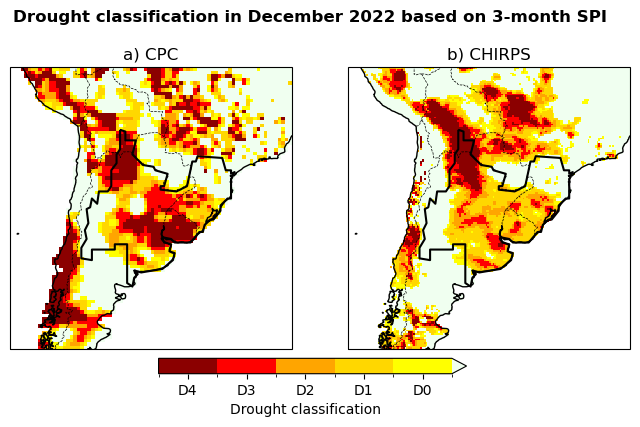

In [141]:
sf = gpd.read_file("sf_CSA-drought").to_crs(cartopy.crs.PlateCarree())

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

cmap = matplotlib.colors.ListedColormap(['darkred', 'red', 'orange', 'gold','yellow']); cmap.set_over('honeydew')
cbar_kwargs = {"location" : "bottom", "fraction" : 0.04, "pad" : 0.07, "shrink" : 0.85, "label" : "Drought classification", "ticks" : list(range(1,6))}
plot_kwargs = {"cmap" : cmap, "norm" : matplotlib.colors.BoundaryNorm(np.arange(0.5,6.5,1), cmap.N), "add_colorbar" : False}

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

fig, axs = plt.subplots(ncols = 2, subplot_kw = {"projection" : cartopy.crs.PlateCarree()}, dpi = 100, figsize = (8,4))

for i in range(len(spi.keys())):
        
    ens = list(spi.keys())[i]
    cbar = spi[ens].plot(ax = axs[i], **plot_kwargs); axs[i].set_title(chr(i+97)+") "+ens.upper())
    
for ax in axs:
    sf.boundary.plot(ax = ax, color = "k", lw = 1.5)
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, ls = "--", alpha = 1, lw = 0.5)
    
cbar = plt.colorbar(cbar, ax = axs, location = "bottom", fraction = 0.05, pad = 0.03, ticks=list(range(1,6)), extend = "max", label = "Drought classification")
cbar.ax.set_xticklabels(["D" + str(x) for x in range(4,-1,-1)])
    
plt.suptitle("Drought classification in December 2022 based on 3-month SPI", fontweight = "bold", y = 1.02)

plt.savefig("event-map_spi3_dec22.png")

### **Drought severity & duration**

In [152]:
from xclim.indices.run_length import rle, _cumsum_reset_on_zero as run_cumsum

for ens in ["cpc", "chirps"]:
    
    da = xr.open_dataset("data/"+ens+"_spi3_monthly.nc").spi
    
    # identify drought months (1 if in drought, 0 otherwise)
    idx_lo = xr.ones_like(da).where(rle(da <= -0.8) > 0)      # indicator for start of drought
    idx_pos = xr.zeros_like(da).where(rle(da > -0.8) > 1)     # indicator for start of non-drought period
    drought_months = xr.concat([idx_lo, idx_pos], "new").max("new").ffill("time")
    
    drought_length = run_cumsum(drought_months.where(drought_months == 1, 0)).where(~np.isnan(da))
    drought_length.rename("drought_duration").assign_attrs(long_name = "Drought duration", units = "months").to_netcdf("data/"+ens+"_spi3-drought-duration.nc")
    
    drought_severity = run_cumsum(da.where(drought_months == 1, 0)).where(~np.isnan(da))
    drought_severity.rename("drought_severity").assign_attrs(long_name = "Drought severity").to_netcdf("data/"+ens+"_spi3-drought-severity.nc")

#### **Map of drought duration**

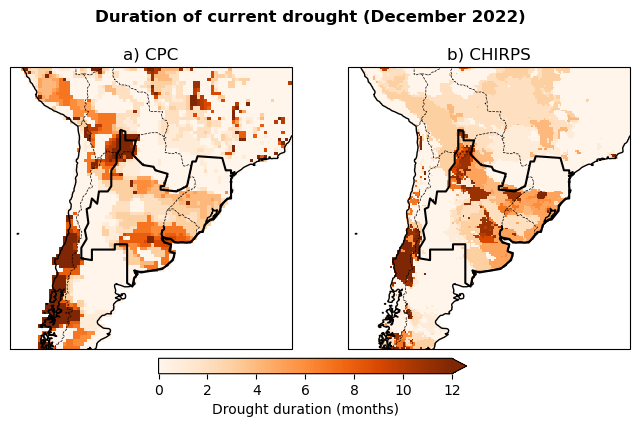

In [175]:
duration = {ens : xr.open_dataset("data/"+ens+"_spi3-drought-duration.nc").drought_duration.sel(time = "2022-12").squeeze(drop = True) for ens in ["cpc", "chirps"]}
sf = gpd.read_file("sf_CSA-drought").to_crs(cartopy.crs.PlateCarree())

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

fig, axs = plt.subplots(ncols = 2, subplot_kw = {"projection" : cartopy.crs.PlateCarree()}, dpi = 100, figsize = (8,4))

for i in range(len(duration.keys())):
        
    ens = list(duration.keys())[i]
    cbar = duration[ens].plot(ax = axs[i], cmap = "Oranges", add_colorbar = False, vmax = 12)
    axs[i].set_title(chr(i+97)+") "+ens.upper())
    
for ax in axs:
    sf.boundary.plot(ax = ax, color = "k", lw = 1.5)
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, ls = "--", alpha = 1, lw = 0.5)
    
cbar = plt.colorbar(cbar, ax = axs, location = "bottom", fraction = 0.05, pad = 0.03, extend = "max", label = "Drought duration (months)")
    
plt.suptitle("Duration of current drought (December 2022)", fontweight = "bold", y = 1.02)

plt.savefig("event-map_drought-duration_dec22.png")

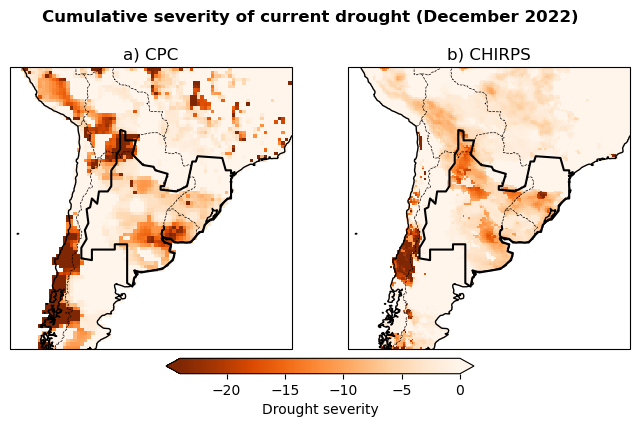

In [176]:
severity = {ens : xr.open_dataset("data/"+ens+"_spi3-drought-severity.nc").drought_severity.sel(time = "2022-12").squeeze(drop = True) for ens in ["cpc", "chirps"]}

sf = gpd.read_file("sf_CSA-drought").to_crs(cartopy.crs.PlateCarree())

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

fig, axs = plt.subplots(ncols = 2, subplot_kw = {"projection" : cartopy.crs.PlateCarree()}, dpi = 100, figsize = (8,4))

for i in range(len(severity.keys())):
        
    ens = list(severity.keys())[i]
    cbar = severity[ens].plot(ax = axs[i], cmap = "Oranges_r", add_colorbar = False, vmax = 0, vmin = -24)
    axs[i].set_title(chr(i+97)+") "+ens.upper())
    
for ax in axs:
    sf.boundary.plot(ax = ax, color = "k", lw = 1.5)
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, ls = "--", alpha = 1, lw = 0.5)
    
cbar = plt.colorbar(cbar, ax = axs, location = "bottom", fraction = 0.05, pad = 0.03, extend = "both", label = "Drought severity")
    
plt.suptitle("Cumulative severity of current drought (December 2022)", fontweight = "bold", y = 1.02)

plt.savefig("event-map_drought-severity_dec22.png")

---
## **Time series for climate explorer**

### **OND precipitation**

In [17]:
sf = gpd.read_file("sf_CSA-drought").to_crs(cartopy.crs.PlateCarree())

for ens in ["cpc", "chirps"]:
    
    csv_fnm = "ts/CSA-drought_pr-ond_"+ens+".dat"
    
    # create extra header lines for upload to Climate Explorer
    str1 = "# contact :: "+ens+" OND precip central South America drought 2023, c.barnes22@imperial.ac.uk"
    str2 = "# precip [mm/day] OND mean precipitation rate at "+re.sub(".dat", "", csv_fnm.split("/")[-1])
    head = "# year precip"
    
    ! echo "$str1 " > $csv_fnm
    ! echo "$str2" >> $csv_fnm
    ! echo "$head" >> $csv_fnm
    
    pr = xr.open_dataset("data/"+ens+"_precip_monthly.nc").sel(time = slice(None, "2022")).precip
    rm = regionmask.mask_3D_geopandas(sf, pr.lon, pr.lat).squeeze(drop = True)
    
    pr_ond = pr.where(rm == 1).mean(["lat", "lon"]).rolling(time = 3).mean().groupby("time.month")[12].dropna("time", "any")
    pr_ond = pr_ond.assign_coords(time = pr_ond.time.dt.year)
    
    pr_ond.to_dataframe().to_csv(csv_fnm, sep = " ", mode = "a", header = False)

### **OND SPI**

In [119]:
sf = gpd.read_file("sf_CSA-drought").to_crs(cartopy.crs.PlateCarree())

for ens in ["cpc", "chirps"]:
    
    pr = xr.open_dataset("data/"+ens+"_precip_monthly.nc").sel(time = slice(None, "2022")).precip
    rm = regionmask.mask_3D_geopandas(sf, pr.lon, pr.lat).squeeze(drop = True)
    
    pr_ond = pr.where(rm == 1).mean(["lat", "lon"]).rolling(time = 3).mean().groupby("time.month")[12].dropna("time", "any")
    spi_ond = get_spi(pr_ond, months = [12]).assign_coords(time = pr_ond.time.dt.year)
        
    csv_fnm = "ts/CSA-drought_spi-ond_"+ens+".dat"
    
    # create extra header lines for upload to Climate Explorer
    str1 = "# contact :: "+ens+" OND SPI central South America drought 2022, c.barnes22@imperial.ac.uk"
    str2 = "# spi [sd] OND SPI normalised against 1980-2010 at "+re.sub(".dat", "", csv_fnm.split("/")[-1])
    head = "# year spi"
    
    ! echo "$str1 " > $csv_fnm
    ! echo "$str2" >> $csv_fnm
    ! echo "$head" >> $csv_fnm
    
    spi_ond.to_dataframe().to_csv(csv_fnm, sep = " ", mode = "a", header = False)

---
## **Seasonal cycle**

In [177]:
# water year starts on July 1st
y_offset = 365-era5.sel(time = "2020-07-01").time.dt.dayofyear

pr = {ens : xr.open_dataset("data/"+ens+"_CSA_daily.nc").precip for ens in ["cpc", "chirps"]}

sc = {ens : da.rolling(time = 15).mean().groupby("time.dayofyear").mean() for ens, da in pr.items()}

In [183]:
from datetime import datetime
datetime(2020,7,1)

AttributeError: 'datetime.datetime' object has no attribute 'dt'

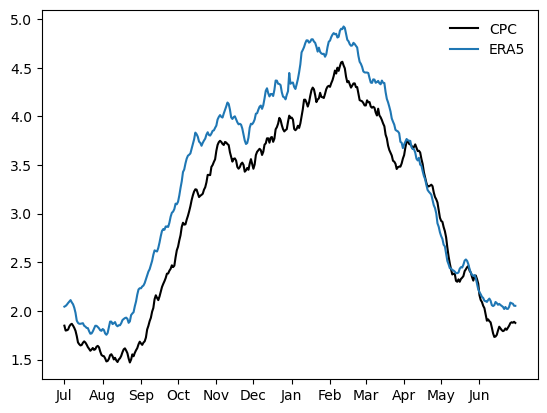

In [35]:
era5 = xr.open_dataset("data/chirps_CSA_daily.nc").precip
cpc = xr.open_dataset("data/cpc_CSA_daily.nc").precip

y_offset = 365-era5.sel(time = "2020-07-01").time.dt.dayofyear

era5_sc = era5.rolling(time = 15).mean().groupby("time.dayofyear").mean()
era5_sc = era5_sc.reindex(dayofyear = era5_sc.dayofyear.sortby((era5_sc.dayofyear + y_offset) % 366))

cpc_sc = cpc.rolling(time = 15).mean().groupby("time.dayofyear").mean()
cpc_sc = cpc_sc.reindex(dayofyear = cpc_sc.dayofyear.sortby((cpc_sc.dayofyear + y_offset) % 366))

plt.plot(cpc_sc, color = "k", label = "CPC")
plt.plot(era5_sc, color = "tab:blue", label = "ERA5")

month_xlabels(era5.sel(time = slice("2019-07-01", "2020-06-30")).time, ax = plt.gcf().axes[0])
plt.legend(edgecolor = "w")

plt.axvline()